# Transfer learning with Resnet and MLP

In [1]:
import numpy as np
from keras.applications import ResNet50
from keras.layers import Input
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from collections import deque
import cv2
import os
from sklearn.model_selection import train_test_split
import splitfolders as splitfolders
from tqdm import tqdm
import math
import random

In [2]:
input_folder = 'Anomaly_Dataset/Anomaly_Videos/'
output_folder = 'Anomaly_Dataset'
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8,.0,.2), group_prefix=None) 

Copying files: 550 files [02:00,  4.57 files/s]


In [3]:
def getSetFiles(path):
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(path):
        for file in filenames:
            fullpath = os.path.join(dirpath,file)
            pathname = os.path.dirname(fullpath)
            foldername = os.path.basename(pathname)
            listOfFiles += [os.path.join(foldername,file)]
    return listOfFiles

In [4]:
def generateTextFile(folder,fileName):
    getSetFiles(folder)
    list1 = getSetFiles(folder)
    with open(fileName, "w+") as output:
        for elem in list1:
            output.write("%s\n" % elem)

In [5]:
generateTextFile("Anomaly_Dataset/test","Anomaly_Dataset/test.txt")
generateTextFile("Anomaly_Dataset/train","Anomaly_Dataset/train.txt")

In [6]:
def openFile(file):
    file = open(file, "r")
    temp = file.read()
    items = temp.split('\n')
    return items

In [7]:
df_test = pd.read_csv("Anomaly_Dataset/test.txt", sep='\\',header=None) 
df_test.columns=['category','video_name']
df_test

,category,video_name
0,Crime,Abuse007_x264.mp4
1,Crime,Abuse009_x264.mp4
2,Crime,Abuse010_x264.mp4
3,Crime,Abuse023_x264.mp4
4,Crime,Abuse024_x264.mp4
...,...,...
105,Normal,Normal_Videos_923_x264.mp4
106,Normal,Normal_Videos_926_x264.mp4
107,Normal,Normal_Videos_930_x264.mp4
108,Normal,Normal_Videos_940_x264.mp4


In [8]:
df_train = pd.read_csv("Anomaly_Dataset/train.txt", sep='\\',header=None) 
df_train.columns=['category','video_name']
df_train

,category,video_name
0,Crime,Abuse001_x264.mp4
1,Crime,Abuse002_x264.mp4
2,Crime,Abuse003_x264.mp4
3,Crime,Abuse004_x264.mp4
4,Crime,Abuse005_x264.mp4
...,...,...
435,Normal,Normal_Videos_937_x264.mp4
436,Normal,Normal_Videos_938_x264.mp4
437,Normal,Normal_Videos_939_x264.mp4
438,Normal,Normal_Videos_941_x264.mp4


In [9]:
## extract frames from training videos

for i in tqdm(range(df_train.shape[0])):
    count = 0
    folderName = df_train['category'][i]
    videoFile = df_train['video_name'][i]
    cap = cv2.VideoCapture('Anomaly_Dataset/train/'+folderName+'/'+videoFile)  # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    x=1

    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames in a new folder named train_img
            
            filename ="Anomaly_Dataset/train_img/" +df_train['category'][i]+'/'+ df_train['video_name'][i].split('.',1)[0] +"_frame%d.jpg" %count;count+=1 
            cv2.imwrite(filename, frame)
    cap.release()

100%|████████████████████████████████████████████████████████████████████████████████| 440/440 [15:49<00:00,  2.16s/it]


In [16]:
# label the training images extracted from the videos

DATADIR = "Anomaly_Dataset\\train_img"
CATEGORIES = ["Crime","Normal"]

train_img=[]

for category in tqdm(CATEGORIES):
    path = os.path.join(DATADIR,category)

    class_num = CATEGORIES.index(category)

    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        width = int(50)
        height = int(50)
        dim = (width, height)
        img_array=cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        img_array = cv2.resize(img_array, dim, interpolation = cv2.INTER_AREA)
            
        #add the images to training set
        train_img.append([img_array,class_num])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.88s/it]


In [11]:
# extract frames from testing videos

for i in tqdm(range(df_test.shape[0])):
    count = 0
    folderName = df_test['category'][i]
    videoFile = df_test['video_name'][i]
    cap = cv2.VideoCapture('Anomaly_Dataset/test/'+folderName+'/'+videoFile)  # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    x=1

    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames in a new folder named train_img
            filename ="Anomaly_Dataset/test_img/" +df_test['category'][i]+'/'+ df_test['video_name'][i].split('.',1)[0] +"_frame%d.jpg" %count;count+=1 
            cv2.imwrite(filename, frame)
    cap.release()

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [04:32<00:00,  2.48s/it]


In [17]:
# label the testing image file

DATADIR = "Anomaly_Dataset\\test_img"
CATEGORIES = ["Crime","Normal"]

test_img=[]

for category in tqdm(CATEGORIES):
    path = os.path.join(DATADIR,category)

    class_num = CATEGORIES.index(category)

    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        width = int(50)
        height = int(50)
        dim = (width, height)
        img_array=cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        img_array = cv2.resize(img_array, dim, interpolation = cv2.INTER_AREA)

            
        #add the images to training set
        test_img.append([img_array,class_num])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:36<00:00, 18.43s/it]


In [18]:
# seperate the image and label to new list and convert them to numpy array 
X_train = []
y_train = []

for frames,label in train_img:
    X_train.append(frames)
    y_train.append(label)
    
X_train = np.array(X_train)
y_train = np.array(y_train)

print("Shape of array X: ",X_train.shape)
print("Shape of array Y: ",y_train.shape)

Shape of array X:  (66033, 50, 50, 3)
Shape of array Y:  (66033,)


In [19]:
# seperate the image and label to new list and convert them to numpy array 
X_test = []
y_test = []

for features,label in test_img:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)
print("Shape of array X_test: ",X_test.shape)
print("Shape of array Y_test: ",y_test.shape)

Shape of array X_test:  (18369, 50, 50, 3)
Shape of array Y_test:  (18369,)


In [20]:
# save numpy array as npy file
from numpy import asarray
from numpy import save

save('x_train.npy', X_train)

save('y_train.npy', y_train)

save('x_test.npy', X_test)

save('y_test1.npy', y_test)


In [2]:
X_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
y_train = to_categorical(y_train)
class_weight = {0: 1, 1: 2.7}

X_test= np.load('X_test.npy')
y_test=np.load('y_test.npy')
y_test = to_categorical(y_test)

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(66033, 50, 50, 3)
(66033, 2)
(18369, 50, 50, 3)
(18369, 2)


In [3]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(50,50,3)))

headModel = baseModel.output
headModel = Flatten()(headModel)
headModel = Dense(500,activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(300,activation="relu")(headModel)
headModel = Dense(150,activation="relu")(headModel)
headModel = Dense(2,activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for basemodelLayers in baseModel.layers:
    basemodelLayers.trainable = False
    
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [6]:
epoch=20
opt = SGD(lr=0.001, momentum=0.9, decay=0.0001)

In [7]:
model.compile(loss="categorical_crossentropy", optimizer=opt, weighted_metrics=["accuracy"])

In [8]:
np.random.shuffle(X_train)
np.random.shuffle(y_train)

In [9]:
callbacks = [
    
    
    tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True,monitor='accuracy')
    

]

In [10]:
History = model.fit(
    X_train,y_train,batch_size=32,
    validation_split=0.2,
    class_weight=class_weight,
    shuffle=True,
    epochs=epoch,
    callbacks=callbacks
)

Epoch 1/20
1651/1651 [==============================] - 486s 294ms/step - loss: 1.0145 - accuracy: 0.5088 - val_loss: 0.6767 - val_accuracy: 0.6744
Epoch 2/20
1651/1651 [==============================] - 483s 292ms/step - loss: 0.9956 - accuracy: 0.5129 - val_loss: 0.6848 - val_accuracy: 0.6686
Epoch 3/20
1651/1651 [==============================] - 482s 292ms/step - loss: 0.9937 - accuracy: 0.5194 - val_loss: 0.6808 - val_accuracy: 0.7011
Epoch 4/20
1651/1651 [==============================] - 482s 292ms/step - loss: 0.9927 - accuracy: 0.5224 - val_loss: 0.6754 - val_accuracy: 0.7160
Epoch 5/20
1651/1651 [==============================] - 483s 292ms/step - loss: 0.9925 - accuracy: 0.5210 - val_loss: 0.6815 - val_accuracy: 0.7009
Epoch 6/20
1651/1651 [==============================] - 484s 293ms/step - loss: 0.9916 - accuracy: 0.5245 - val_loss: 0.6783 - val_accuracy: 0.7106
Epoch 7/20
1651/1651 [==============================] - 501s 303ms/step - loss: 0.9915 - accuracy: 0.5235 - val_

In [11]:
model.save("MLP_RESNET.h5")

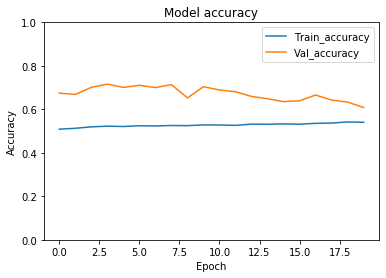

In [12]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.legend(['Train_accuracy', 'Val_accuracy'], loc='upper right')
plt.show()

In [13]:
np.random.shuffle(X_test)
np.random.shuffle(y_test)

test_loss, test_accuracy = model.evaluate(X_test,y_test, verbose=1)

print("Testing Accuracy = ", test_accuracy)

575/575 [==============================] - 134s 232ms/step - loss: 0.6807 - accuracy: 0.6204
Testing Accuracy =  0.6203930377960205


# Model 2

In [20]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(50,50,3)))

headModel = baseModel.output
headModel = Flatten()(headModel)
headModel = Dense(1000,activation="relu")(headModel)
headModel = Dense(500,activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(300,activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(150,activation="relu")(headModel)
headModel = Dense(2,activation="softmax")(headModel)

model2 = Model(inputs=baseModel.input, outputs=headModel)

for basemodelLayers in baseModel.layers:
    basemodelLayers.trainable = False
    
model2.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [21]:
opt = SGD(lr=0.005, momentum=0.9, decay=0.0001)

In [22]:
model2.compile(loss="categorical_crossentropy", optimizer=opt, weighted_metrics=["accuracy"])

In [23]:
np.random.shuffle(X_train)
np.random.shuffle(y_train)

In [24]:
callbacks = [
    
    
    tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True,monitor='accuracy')
    
]

In [25]:
History2 = model2.fit(
    X_train,y_train,batch_size=32,
    validation_split=0.2,
    shuffle=True,
    epochs=25,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 1/25
1651/1651 [==============================] - 547s 331ms/step - loss: 1.0110 - accuracy: 0.5048 - val_loss: 0.6851 - val_accuracy: 0.7366
Epoch 2/25
1651/1651 [==============================] - 544s 330ms/step - loss: 0.9958 - accuracy: 0.5107 - val_loss: 0.6753 - val_accuracy: 0.7442
Epoch 3/25
1651/1651 [==============================] - 578s 350ms/step - loss: 0.9953 - accuracy: 0.5140 - val_loss: 0.6814 - val_accuracy: 0.7442
Epoch 4/25
1651/1651 [==============================] - 566s 343ms/step - loss: 0.9947 - accuracy: 0.5157 - val_loss: 0.6770 - val_accuracy: 0.7442
Epoch 5/25
1651/1651 [==============================] - 534s 323ms/step - loss: 0.9946 - accuracy: 0.5144 - val_loss: 0.6727 - val_accuracy: 0.7442
Epoch 6/25
1651/1651 [==============================] - 538s 326ms/step - loss: 0.9944 - accuracy: 0.5184 - val_loss: 0.6789 - val_accuracy: 0.7442
Epoch 7/25
1651/1651 [==============================] - 540s 327ms/step - loss: 0.9943 - accuracy: 0.5181 - val_

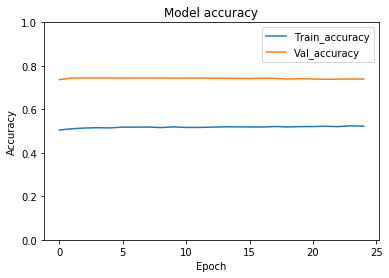

In [28]:
plt.plot(History2.history['accuracy'])
plt.plot(History2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.legend(['Train_accuracy', 'Val_accuracy'], loc='upper right')
plt.show()

In [29]:
np.random.shuffle(X_test)
np.random.shuffle(y_test)

test_loss, test_accuracy = model2.evaluate(X_test,y_test, verbose=1)

print("Testing Accuracy = ", test_accuracy)

575/575 [==============================] - 138s 240ms/step - loss: 0.6783 - accuracy: 0.7333
Testing Accuracy =  0.7333006858825684


## Demo

In [30]:
total_labels = np.concatenate((y_train, y_test), axis=0)
labelbin = LabelBinarizer()
lb = labelbin.fit_transform(total_labels)

In [31]:
# open the video file to classify
capture = cv2.VideoCapture(r"test_video.mp4")
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))   # float
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float
Queue = deque(maxlen=160)
writer = None

In [ ]:
# loop over frames from the video file stream
while True:
    
    # read the next frame from the file
    (grabbed, frame) = capture.read()

    # if the frame was not grabbed, then we have reached the end of the stream
    if not grabbed:
        break


    # clone the output frame # ordering, resize the frame to a fixed 224x224, and then perform mean subtraction
    output = frame.copy()
    frame = cv2.resize(frame,(50,50))
    
    # make predictions on the frame and then update the predictions queue
    preds = model.predict(np.expand_dims(frame,axis=0))
    Queue.append(preds)

    # perform prediction averaging over the current history of previous predictions
    results = np.array(Queue).mean(axis=0)
    i = np.argmax(results)
    label = labelbin.classes_[int(i)]
    
    # draw the activity on the output frame
    if label ==0:
        text = "Crime Detected"
    if label ==1:
        text = "No Crime Detected"
        
    cv2.putText(output, text, (25, 20), cv2.FONT_HERSHEY_SIMPLEX,1, (0, 255, 0), 2)

    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter("output_resnet-mlp.avi", fourcc, 30,(width, height))

    # write the output frame to disk
    writer.write(output)

    # show the output image
    cv2.imshow("Output", output)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# release the file pointers
writer.release()
capture.release()
cv2.destroyAllWindows()